In [1]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.insert(0, "../code")
import data_degrading as dd

from icecream import ic
from importlib import reload

figdir = "./"

In [2]:
df = pd.read_parquet("../data/original_resolution_parquet/original_data.parquet")
df_R100 = pd.read_parquet("../df_R100.parquet")
df_R25 = pd.read_parquet("../df_R25.parquet")

In [3]:
def adjust_logbins(bins, current="center", new="leftedge"):
    """
    Redefines whether an array corresponds to bin centers or bin edges.

    Assuming the bins have a constant spacing in log-space (that is:
    ``np.diff(np.log(bins))`` is a constant array) then this function will
    shift the bins from bin-center-defined to bin-edge-defined or vice versa.

    Arguments
    ---------
    bins : array-like
        One dimensional array of bin positions.
    current : {"center", "leftedge",}, default: "center"
        Whether the bins array currently defines the bin centers or left edge.
    new : {"center", "leftedge"}, default: "leftedge"
        What the returned bins array should define: the bin centers or the left
        bin edge.

    Returns
    -------
    new_bins : array-like
        One dimensional array of new bin positions.
    """

    logbin = np.log(bins)
    d_logbin = np.mean(np.diff(logbin))

    if current == "center" and new == "leftedge":
        # diff_logbin / 2 will give the bin radius in log space. If our array
        # denotes bin-centers, then we need to subtract the bin radius from
        # the array so that now the array is denoting left-bin-edges.
        # Also note we need to add one more bin in log space before we take
        # np.diff. This is so that when we subtract arrays of the same shape
        # in the next line.
        bin_radii = np.diff(logbin, append=logbin[-1]+d_logbin)
        new_logbins = logbin - bin_radii * 0.5
        new_bins = np.exp(new_logbins)

    elif current == "leftedge" and new == "center":
        bin_widths = np.diff(logbin, append=logbin[-1]+d_logbin)
        new_logbins = logbin + bin_widths * 0.5
        new_bins = np.exp(new_logbins)

    return new_bins



@np.vectorize
def wavelen2rgb(nm):
    """
    Converts a wavelength between 380 and 780 nm to an RGB color tuple.

    Willow: This code taken from rsmith-nl/wavelength_to_rgb git repo.

    Arguments
    ---------
        nm : float
            Wavelength in nanometers.
    Returns
    -------
        rgb : 3-tuple
            tuple (red, green, blue) of integers in the range 0-255.
    """
    def adjust(color, factor):
        if color < 0.01:
            return 0
        max_intensity = 255
        gamma = 0.80
        rv = int(round(max_intensity * (color * factor)**gamma))
        if rv < 0:
            return 0
        if rv > max_intensity:
            return max_intensity
        return rv

    # if nm < 380 or nm > 780:
    #     raise ValueError('wavelength out of range')
    if nm < 380:
        nm = 380
    if nm > 780:
        nm = 780
    
    red = 0.0
    green = 0.0
    blue = 0.0
    # Calculate intensities in the different wavelength bands.
    if nm < 440:
        red = -(nm - 440.0) / (440.0 - 380.0)
        blue = 1.0
    elif nm < 490:
        green = (nm - 440.0) / (490.0 - 440.0)
        blue = 1.0
    elif nm < 510:
        green = 1.0
        blue = -(nm - 510.0) / (510.0 - 490.0)
    elif nm < 580:
        red = (nm - 510.0) / (580.0 - 510.0)
        green = 1.0
    elif nm < 645:
        red = 1.0
        green = -(nm - 645.0) / (645.0 - 580.0)
    else:
        red = 1.0
    # Let the intensity fall off near the vision limits.
    if nm < 420:
        factor = 0.3 + 0.7 * (nm - 380.0) / (420.0 - 380.0)
    elif nm < 701:
        factor = 1.0
    else:
        factor = 0.3 + 0.7 * (780.0 - nm) / (780.0 - 700.0)
    # Return the calculated values in an (R,G,B) tuple.
    return (adjust(red, factor), adjust(green, factor), adjust(blue, factor))

In [4]:
def plot_example_specs(df_list, R_list, sn_name, sn_phase, suptitle):

    assert len(df_list) == len(R_list)
    plt.rcParams["font.family"] = "serif"

    num_plots = len(df_list)
    fig, axes = plt.subplots(num_plots, 1, sharex=True, sharey=True, figsize=(10, 14))
    fig.subplots_adjust(hspace=0, wspace=0)

    for i, (df, R) in enumerate(zip(df_list, R_list)):
        wvl, flux = get_spec(sn_name, sn_phase, df)

        flux -= flux.min() - flux.max() * 0.05
        flux /= flux.max()
        flux[(wvl < 4000) | (wvl > 7000)] = 0

        if not np.any(wvl > 7000):
            RGB = wavelen2rgb(wvl/10)
            RGBA = np.array(RGB).T / 255.
        else:
            # If there are wavelength points above 7000 angstroms, make them an
            # RGB value corresponding to 7000 angstroms. This RGB code can't
            # handle wavelengths not between 4000 and 7000 angstroms.
            over7000 = np.where(wvl > 7000)[0]
            wvl_copy = wvl.copy()
            wvl_copy[over7000] = 7000
            RGB = wavelen2rgb(wvl_copy/10)
            RGBA = np.array(RGB).T / 255.

        assert wvl.size == flux.size

        # wvl defines bin-centers. We want left edges of bin for plotting.
        wvl_LE = adjust_logbins(wvl)

        axes[i].plot(
            wvl[:-1], flux[:-1],
            ls="-", c="k", marker=""
        )
        _, _, patches = axes[i].hist(
            wvl_LE[:-1], bins=wvl_LE,
            weights=flux[:-1], align="mid"
        )

        # Each patch of the histogram (the rectangle underneath each point) gets
        # colored according to its central wavelength.
        for patch, color in zip(patches, RGBA):
            patch.set_facecolor(color)

        axes[i].set_xticks(
            np.arange(4000, 7000+1, 100),
            [],
            minor=True
        )
        axes[i].set_xticks(
            np.arange(4000, 7000+1, 500),
            np.arange(4000, 7000+1, 500),
            minor=False,
            fontsize=15, rotation=30
        )

        axes[i].set_yticks(
            [],
            [],
            minor=True
        )
        axes[i].set_yticks(
            np.arange(0, 1+0.2, 0.2),
            ["0", ".2", ".4", ".6", ".8", "1"],
            minor=False,
            fontsize=15
        )

        axes[i].annotate(
            f"R = {R}",
            xy=(4100, 1),
            size=20, weight="bold"
            # ha="right", va="top",
        )

    axes[2].set_xlabel(r"Wavelength [$\AA$]", fontsize=20)
    axes[1].set_ylabel(r"Normalized Flux [$F_{\lambda}$]", fontsize=20)

    axes[2].set_xlim((4000, 7000))
    axes[2].set_ylim((0, 1.1))
    if suptitle:
        if sn_phase > 0:
            fig.suptitle(f"{sn_name}\n{sn_phase} days after peak brightness")
        elif sn_phase < 0:
            fig.suptitle(f"{sn_name}\n{np.abs(sn_phase)} days before peak brightness")
        elif sn_phase == 0:
            fig.suptitle(f"{sn_name}\nat peak brightness")

    plt.tight_layout()

    return fig

In [5]:
def get_spec(sn_name, sn_phase, df):
    assert sn_name in df.index
    assert sn_phase in df.loc[sn_name]["Spectral Phase"].values, df.loc[sn_name]["Spectral Phase"]

    row = df[(df.index == sn_name) & (df["Spectral Phase"] == sn_phase)]
    wvl = row.columns[5:].values.astype(float)
    spec = row.iloc[:, 5:].values[0]
    return wvl, spec

In [6]:
df_list = [df, df_R100, df_R25]
R_list = [738, 100, 25]
sn_name = "sn1998dt"
sn_phase = 1.8

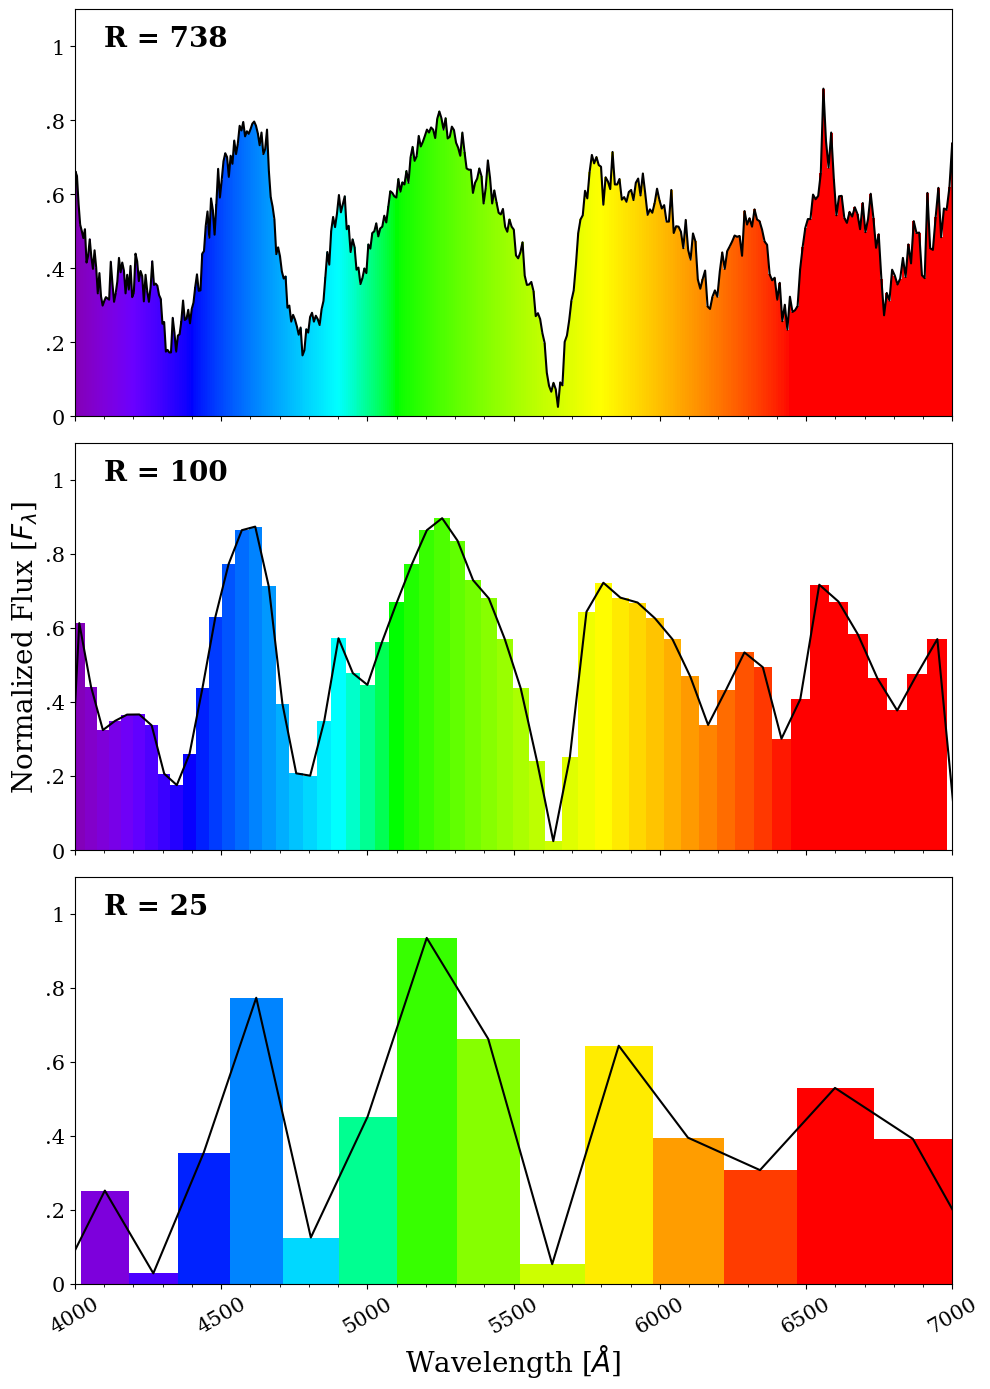

In [7]:
fig = plot_example_specs(df_list, R_list, sn_name, sn_phase, suptitle=False)
fig.savefig(os.path.join(figdir, "example_specs_og_hi_lo_notitle.pdf"))
fig.savefig(os.path.join(figdir, "example_specs_og_hi_lo_notitle.png"))
fig.show()

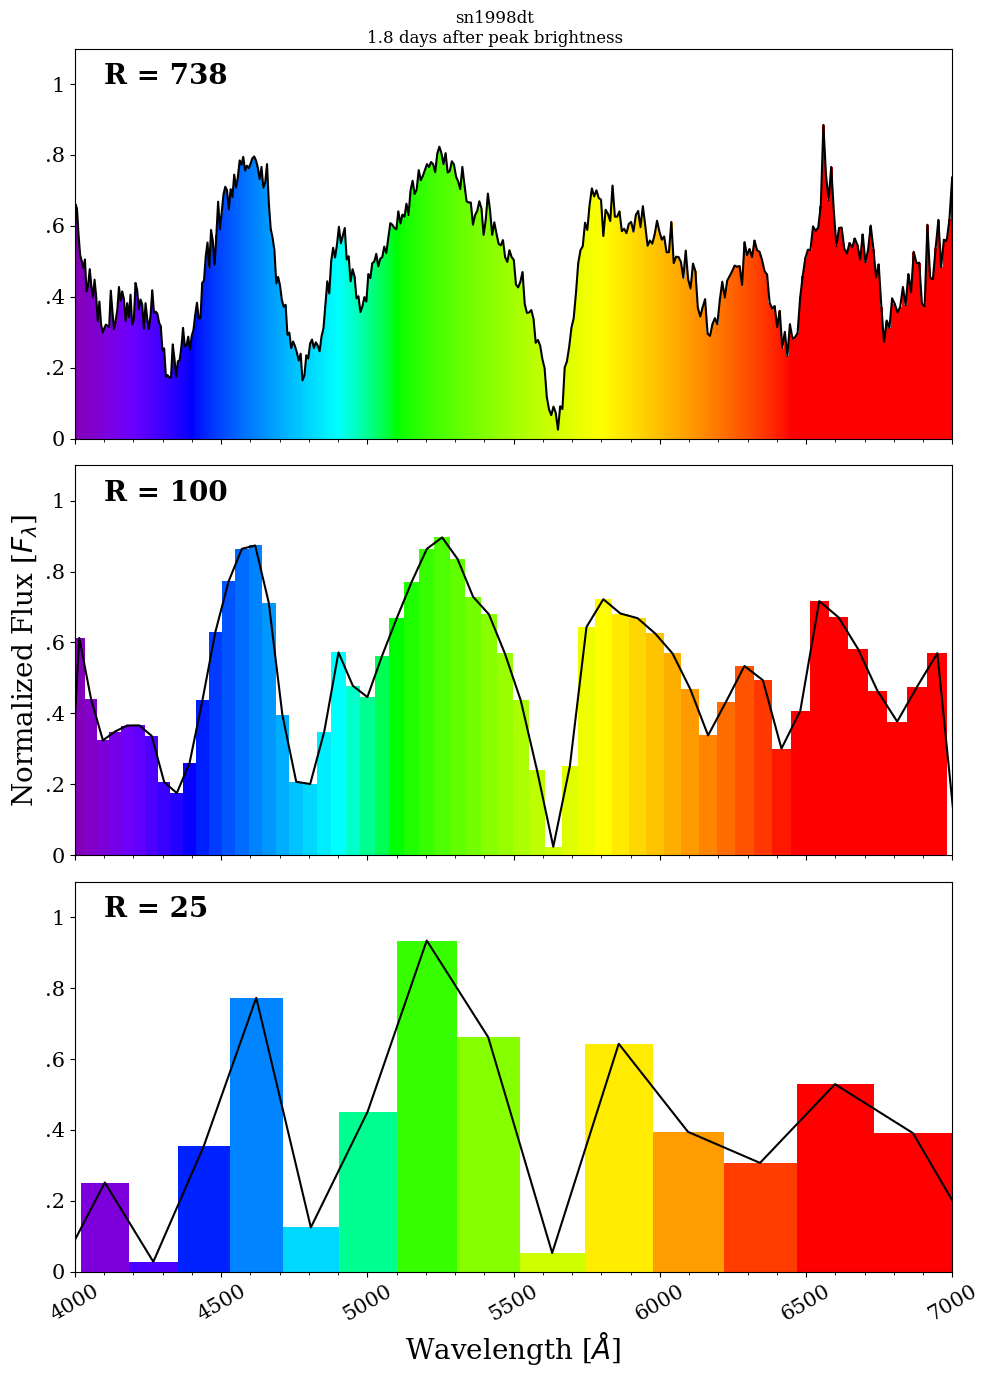

In [8]:
fig = plot_example_specs(df_list, R_list, sn_name, sn_phase, suptitle=True)
fig.savefig(os.path.join(figdir, "example_specs_og_hi_lo_.pdf"))
fig.savefig(os.path.join(figdir, "example_specs_og_hi_lo_.png"))
fig.show()